# 가상 데이터 생성

In [1]:
# 주피터 노트북 전체화면 설정
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. 분 단위 전압 데이터 생성
- #1 BUS 전압만 고려

In [2]:
# 계측값이력 데이터
data_measured = pd.read_excel('./계측값이력_2021년09월27일15시54분40초.xlsx', header=11, index_col=0)

# 최대값, 최소값, 평균값 행 제거
data_measured = data_measured[3:]

# index 초기화
data_measured.reset_index(inplace = True)

# 필요한 칼럼만 추출
data_measured = data_measured[['시각', '345kV PT #1 BUS METERING P.T A상 전압']]

# 9월 데이터만 추출
sep = data_measured[data_measured['시각'].apply(lambda x: x[5:7]) == '09']
sep.reset_index(inplace = True, drop = True)
sep.columns = ['시각', '전압']
sep = sep[:-11]

# 결과
sep

,시각,전압
0,2021년09월01일 00시,355.70
1,2021년09월01일 01시,357.21
2,2021년09월01일 02시,357.84
3,2021년09월01일 03시,358.89
4,2021년09월01일 04시,359.30
...,...,...
541,2021년09월23일 19시,353.40
542,2021년09월23일 20시,353.92
543,2021년09월23일 21시,354.44
544,2021년09월23일 22시,355.17


#### 데이터 생성 방법  

1. 정규분포를 통해 생성
- "Voltage fluctuations are systemic variations of the voltage envelope or random voltage changes, the magnitude of which does not normally exceed specified voltage ranges."  
- "전압 변동은 일반적으로 지정된 전압 범위를 초과하지 않는다."  
- 정규분포를 이용하여 평균으로부터 약간의 변동을 표현하되, 보다 세밀한 데이터 생성과 기존의 데이터 활용을 위해 시간별 평균을 이용  
- 평균 = 현재 보유한 시간마다의 평균 전압을 이용  
- 표준편차 = 시간마다의 전압 표준편차를 알 수 없으므로 같은 날, 각 시간대 평균 전압의 표준편차를 이용  
- 이를 통해 각 시간 사이의 분 단위 전압 데이터를 임의로 생성  
  
#### + 추가  
- 사실 가상 데이터 자체의 신뢰성은 고려할 필요가 없음  
- 회사가 원하는 것은 추후 필요한 데이터가 수집되었을 때, 직접 학습하여 사용할 수 있는 모델과 이를 활용한 시스템을 만들어주는 것 (미팅 논의 내용)   
- 따라서, 아무리 가상 데이터를 합리적으로 만들더라도 결국은 추후에 회사측에서 새로운 데이터로 다시 훈련할 것이므로 그 의미가 적음  
- 가상 데이터 생성은 학습 가능한 모델을 만드는 과정을 위한 한 과정일 뿐이기 때문에 많은 현실성과 합리성을 고려할 필요는 없음  

In [3]:
# 필요한 정보 추출
day = sep['시각'].apply(lambda x : x[8:10])
hour = sep['시각'].apply(lambda x : x[12:14])
sep.loc[:,'일'] = day
sep.loc[:,'시'] = hour

# 각 일별 평균 전압의 표준편차 계산
sep_stds = sep.groupby('일')['전압'].std()

# 결과
sep_stds

일
01    1.860333
02    1.689813
03    1.489809
04    1.258243
05    0.983901
06    2.142786
07    2.350411
08    2.261586
09    1.417873
10    2.304826
11    1.745410
12    1.655054
13    1.784729
14    1.845357
15    1.421728
16    1.449559
17    1.288119
18    1.620555
19    1.754967
20    1.475241
21    0.762439
22    1.107367
23    1.116037
Name: 전압, dtype: float64

In [4]:
# 정규분포를 통해 데이터 생성
# 결측된 시간대 고려 (이전 시간의 평균값 사용)

hour_prev = -1

data = []

for i in range(len(sep)) :
    
    # 평균 추출
    mean = sep.loc[i,'전압']
    
    # 표준편차 추출
    day = sep.loc[i, '일']
    std = sep_stds.loc[day]
    
    # 누락 시간대를 위한 시간 추출
    hour = sep.loc[i, '시']
    dist = int(hour) - int(hour_prev)
    
    # 누락 시간대에 대해 이전 시간대의 평균값을 다시 사용 
    if (dist != 1) and (dist != -23) :
        
        d = np.random.normal(mean, std, 120)
    
    else :
        d = np.random.normal(mean, std, 60)
    
    hour_prev = hour
    
    data.append(d)
    
# 데이터 결합
data = np.hstack(data)

# 1분단위 시간 범위 생성
sep_range = pd.date_range('2021-09-01', '2021-09-24', freq = '1min')
sep_range = sep_range[:-1]

# 데이터프레임 다시 생성
sep_df = pd.DataFrame({'시각' : sep_range, '전압' : data})

# 데이터 생성 결과
sep_df

,시각,전압
0,2021-09-01 00:00:00,356.974375
1,2021-09-01 00:01:00,355.517814
2,2021-09-01 00:02:00,355.649576
3,2021-09-01 00:03:00,354.302335
4,2021-09-01 00:04:00,360.352071
...,...,...
33115,2021-09-23 23:55:00,353.542734
33116,2021-09-23 23:56:00,353.457507
33117,2021-09-23 23:57:00,353.489307
33118,2021-09-23 23:58:00,351.490017


- 나머지 3월, 4월, ... 의 데이터도 동일한 방식으로 생성 후 데이터프레임 결합  

In [5]:
# 생성 결과
all_df = pd.read_csv('전압데이터.csv')
all_df['시각'] = pd.to_datetime(all_df['시각'])
all_df

,시각,전압
0,2021-03-01 00:00:00,349.597094
1,2021-03-01 00:01:00,353.676500
2,2021-03-01 00:02:00,353.876387
3,2021-03-01 00:03:00,352.550220
4,2021-03-01 00:04:00,354.762645
...,...,...
298075,2021-09-23 23:55:00,355.100535
298076,2021-09-23 23:56:00,353.687462
298077,2021-09-23 23:57:00,353.178419
298078,2021-09-23 23:58:00,354.129281


## 2. 차단기 및 가변형 리액터 정보 반영  
- 가변형 리액터 1개, 일반 리액터 2개만을 고려 (미팅 논의 내용)  
- 리액터는 가장 많이 사용된 리액터 3개만을 고려  
- 생성한 데이터(all_df)에 일반 리액터 및 가변형 리액터 탭 정보를 나타내는 칼럼 추가
- 디폴트 값 : 차단기 = 정상, 탭 = 0 (차단기가 열린 후 언제 닫히는지를 구분하기 위해)
- 알람 이력 데이터를 통해 '분' 기준으로 차단기가 열린 경우 표시  
- 차단기가 열렸을 경우 기본 탭 = 1 (가변형 리액터를 사용하고 있다고 가정하므로)

### 2.1. 가변형 리액터 1

In [6]:
# 알람이력 데이터
data_alarm = pd.read_excel('./알람이력_2021년09월27일16시00분21초.xlsx', header=4, index_col=0)

# 가변형 리액터 1
data_alarm = data_alarm[data_alarm['Name'] == '345 #4Sh.R 7479 CB']

# 필요한 칼럼만 추출
data_alarm.reset_index(inplace = True)
data_alarm = data_alarm[['TimeStamp', 'Value']]
data_alarm.columns = ['시각', '상태']


# 필요한 정보 추출
data_alarm['월'] = data_alarm['시각'].apply(lambda x : x[5:7]).astype('int')
data_alarm['일'] = data_alarm['시각'].apply(lambda x : x[8:10]).astype('int')
data_alarm['시'] = data_alarm['시각'].apply(lambda x : x[11:13]).astype('int')
data_alarm['분'] = data_alarm['시각'].apply(lambda x : x[14:16]).astype('int')

# 결과
data_alarm = data_alarm[:-1]
data_alarm

,시각,상태,월,일,시,분
0,2021-03-01 09:30:12.618,열림,3,1,9,30
1,2021-03-01 23:39:09.335,닫힘,3,1,23,39
2,2021-03-02 08:01:24.067,열림,3,2,8,1
3,2021-03-02 19:33:15.340,닫힘,3,2,19,33
4,2021-03-03 08:00:29.699,열림,3,3,8,0
...,...,...,...,...,...,...
361,2021-09-21 21:29:12.314,닫힘,9,21,21,29
362,2021-09-22 08:45:58.054,열림,9,22,8,45
363,2021-09-22 21:26:32.822,닫힘,9,22,21,26
364,2021-09-23 08:59:48.213,열림,9,23,8,59


In [7]:
all_df['가변1'] = '정상'
all_df['탭1'] = 0

for i in range(len(data_alarm)) :
    month = data_alarm.loc[i,'월']
    day = data_alarm.loc[i,'일']
    hour = data_alarm.loc[i,'시']
    mi = data_alarm.loc[i,'분']
    st = data_alarm.loc[i,'상태']
    
    aa = all_df[all_df['시각'].apply(lambda x : x.month) == month]
    aa = aa[aa['시각'].apply(lambda x : x.day) == day]
    aa = aa[aa['시각'].apply(lambda x : x.hour) == hour]
    aa = aa[aa['시각'].apply(lambda x : x.minute) == mi]
    
    all_df.loc[aa.index[0], '가변1'] = st
    
    if st == '열림' :
        all_df.loc[aa.index[0], '탭1'] = 1
    else :
        all_df.loc[aa.index[0], '탭1'] = 0
    
# 결과
all_df[all_df['가변1'] == '열림']

,시각,전압,가변1,탭1
570,2021-03-01 09:30:00,351.961685,열림,1
1921,2021-03-02 08:01:00,352.094368,열림,1
3360,2021-03-03 08:00:00,351.071026,열림,1
4816,2021-03-04 08:16:00,350.814061,열림,1
10553,2021-03-08 07:53:00,362.475154,열림,1
...,...,...,...,...
290004,2021-09-18 09:24:00,351.257193,열림,1
292764,2021-09-20 07:24:00,351.937547,열림,1
294239,2021-09-21 07:59:00,350.370277,열림,1
295725,2021-09-22 08:45:00,348.854725,열림,1


- 열렸다가 닫히기 전까지 차단기는 열려있음
- 차단기가 열리기 전에는 닫혀있음

In [8]:
base = 0
ind_list_open = []
ind_list_close = []

for i in range(len(all_df)) :
    
    st = all_df.loc[i, '가변1']
    
    if st == '열림' :
        base = '열림'
        
    if base == '열림' :
        ind_list_open.append(i)
        
    if st == '닫힘' :
        base = '닫힘'
    
    if base == '닫힘' :
        ind_list_close.append(i)

# 결과 반영
all_df.loc[ind_list_open, '가변1'] = '열림'
all_df.loc[ind_list_open, '탭1'] = 1
all_df.loc[ind_list_close, '가변1'] = '닫힘'
all_df.loc[ind_list_close, '탭1'] = 0
all_df.loc[all_df['가변1'] == '정상', '가변1'] = '닫힘'

# 결과
all_df['가변1'].value_counts()

닫힘    210048
열림     88032
Name: 가변1, dtype: int64

In [9]:
# 적용 예시 : 닫힘 -> 열림 -> 닫힘
all_df[568:1420]

,시각,전압,가변1,탭1
568,2021-03-01 09:28:00,354.137765,닫힘,0
569,2021-03-01 09:29:00,352.219098,닫힘,0
570,2021-03-01 09:30:00,351.961685,열림,1
571,2021-03-01 09:31:00,351.786603,열림,1
572,2021-03-01 09:32:00,353.370125,열림,1
...,...,...,...,...
1415,2021-03-01 23:35:00,353.807687,열림,1
1416,2021-03-01 23:36:00,355.950032,열림,1
1417,2021-03-01 23:37:00,354.905307,열림,1
1418,2021-03-01 23:38:00,355.904201,열림,1


- 여러 탭 수준 설정  
- 열려있는 가변형 리액터에 대해 1 ~ 18 까지 다양한 탭 수준을 설정  
- 탭 변경은 1분 이내에 모두 완료된다고 가정  

In [10]:
# 열려있는 가변형 리액터에 대해 1 ~ 18까지 다양한 탭 수준을 설정
all_df_v_open = all_df[all_df['가변1'] == '열림']
all_df_v_open['탭1'] = np.random.randint(1,19, len(all_df_v_open))

# 결과
all_df_v_open['탭1'].value_counts()

<ipython-input-10-3f8ad51f5434>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df_v_open['탭1'] = np.random.randint(1,19, len(all_df_v_open))


9     4985
3     4982
10    4981
4     4972
16    4942
7     4914
12    4911
11    4898
14    4892
6     4884
8     4877
2     4859
17    4846
15    4844
5     4836
1     4823
13    4799
18    4787
Name: 탭1, dtype: int64

In [11]:
# 결과 반영
ind = all_df_v_open.index
value = all_df_v_open['탭1'].values

all_df.loc[ind, '탭1'] = value

# 결과
all_df['탭1'].value_counts()

0     210048
9       4985
3       4982
10      4981
4       4972
16      4942
7       4914
12      4911
11      4898
14      4892
6       4884
8       4877
2       4859
17      4846
15      4844
5       4836
1       4823
13      4799
18      4787
Name: 탭1, dtype: int64

### 2.2. 일반 리액터 1

In [12]:
# 알람이력 데이터
data_alarm = pd.read_excel('./알람이력_2021년09월27일16시00분21초.xlsx', header=4, index_col=0)

# 일반 리액터 1
data_alarm = data_alarm[data_alarm['Name'] == '345 #3Sh.R 7379 CB']

# 필요한 칼럼만 추출
data_alarm.reset_index(inplace = True)
data_alarm = data_alarm[['TimeStamp', 'Value']]
data_alarm.columns = ['시각', '상태']

# 필요한 정보 추출
data_alarm['월'] = data_alarm['시각'].apply(lambda x : x[5:7]).astype('int')
data_alarm['일'] = data_alarm['시각'].apply(lambda x : x[8:10]).astype('int')
data_alarm['시'] = data_alarm['시각'].apply(lambda x : x[11:13]).astype('int')
data_alarm['분'] = data_alarm['시각'].apply(lambda x : x[14:16]).astype('int')

# 결과
data_alarm = data_alarm[:-1]
data_alarm

,시각,상태,월,일,시,분
0,2021-03-05 14:00:56.820,열림,3,5,14,0
1,2021-03-05 15:05:26.086,닫힘,3,5,15,5
2,2021-03-10 10:33:09.285,열림,3,10,10,33
3,2021-03-10 22:32:01.809,닫힘,3,10,22,32
4,2021-03-11 06:30:35.404,열림,3,11,6,30
...,...,...,...,...,...,...
193,2021-09-13 20:20:19.251,닫힘,9,13,20,20
194,2021-09-19 18:45:07.686,열림,9,19,18,45
195,2021-09-19 20:50:24.204,닫힘,9,19,20,50
196,2021-09-20 10:04:56.675,열림,9,20,10,4


In [13]:
all_df['일반1'] = '정상'

for i in range(len(data_alarm)) :
    month = data_alarm.loc[i,'월']
    day = data_alarm.loc[i,'일']
    hour = data_alarm.loc[i,'시']
    mi = data_alarm.loc[i,'분']
    st = data_alarm.loc[i,'상태']
    
    aa = all_df[all_df['시각'].apply(lambda x : x.month) == month]
    aa = aa[aa['시각'].apply(lambda x : x.day) == day]
    aa = aa[aa['시각'].apply(lambda x : x.hour) == hour]
    aa = aa[aa['시각'].apply(lambda x : x.minute) == mi]
    
    all_df.loc[aa.index[0], '일반1'] = st
    
# 결과
all_df[all_df['일반1'] == '열림']

,시각,전압,가변1,탭1,일반1
6600,2021-03-05 14:00:00,359.780963,닫힘,0,열림
13593,2021-03-10 10:33:00,353.695276,열림,14,열림
14790,2021-03-11 06:30:00,351.851609,열림,3,열림
14880,2021-03-11 08:00:00,355.475839,열림,18,열림
36525,2021-03-26 08:45:00,353.457997,닫힘,0,열림
...,...,...,...,...,...
277036,2021-09-09 09:16:00,352.619608,열림,5,열림
278533,2021-09-10 10:13:00,352.317103,열림,10,열림
282777,2021-09-13 08:57:00,354.572215,열림,8,열림
292005,2021-09-19 18:45:00,351.917978,닫힘,0,열림


In [14]:
base = 0
ind_list_open = []
ind_list_close = []

for i in range(len(all_df)) :
    
    st = all_df.loc[i, '일반1']
    
    if st == '열림' :
        base = '열림'
        
    if base == '열림' :
        ind_list_open.append(i)
        
    if st == '닫힘' :
        base = '닫힘'
    
    if base == '닫힘' :
        ind_list_close.append(i)

# 결과 반영
all_df.loc[ind_list_open, '일반1'] = '열림'
all_df.loc[ind_list_close, '일반1'] = '닫힘'
all_df.loc[all_df['일반1'] == '정상', '일반1'] = '닫힘'

# 결과
all_df['일반1'].value_counts()

닫힘    240884
열림     57196
Name: 일반1, dtype: int64

In [15]:
# 적용 예시 : 닫힘 -> 열림 -> 닫힘
all_df[6599:6668]

,시각,전압,가변1,탭1,일반1
6599,2021-03-05 13:59:00,358.238089,닫힘,0,닫힘
6600,2021-03-05 14:00:00,359.780963,닫힘,0,열림
6601,2021-03-05 14:01:00,357.964150,닫힘,0,열림
6602,2021-03-05 14:02:00,357.799781,닫힘,0,열림
6603,2021-03-05 14:03:00,354.869958,닫힘,0,열림
...,...,...,...,...,...
6663,2021-03-05 15:03:00,357.068430,닫힘,0,열림
6664,2021-03-05 15:04:00,356.759885,닫힘,0,열림
6665,2021-03-05 15:05:00,360.132292,닫힘,0,닫힘
6666,2021-03-05 15:06:00,355.256591,닫힘,0,닫힘


### 2.3. 일반 리액터 2

In [16]:
# 알람이력 데이터
data_alarm = pd.read_excel('./알람이력_2021년09월27일16시00분21초.xlsx', header=4, index_col=0)

# 일반 리액터 2
data_alarm = data_alarm[data_alarm['Name'] == '345 #5Sh.R 7579 CB']

# 필요한 칼럼만 추출
data_alarm.reset_index(inplace = True)
data_alarm = data_alarm[['TimeStamp', 'Value']]
data_alarm.columns = ['시각', '상태']

# 필요한 정보 추출
data_alarm['월'] = data_alarm['시각'].apply(lambda x : x[5:7]).astype('int')
data_alarm['일'] = data_alarm['시각'].apply(lambda x : x[8:10]).astype('int')
data_alarm['시'] = data_alarm['시각'].apply(lambda x : x[11:13]).astype('int')
data_alarm['분'] = data_alarm['시각'].apply(lambda x : x[14:16]).astype('int')

# 결과
data_alarm

,시각,상태,월,일,시,분
0,2021-03-02 09:44:56.577,열림,3,2,9,44
1,2021-03-02 19:58:58.470,닫힘,3,2,19,58
2,2021-03-07 11:28:16.209,열림,3,7,11,28
3,2021-03-07 16:56:44.824,닫힘,3,7,16,56
4,2021-03-09 08:22:42.831,열림,3,9,8,22
...,...,...,...,...,...,...
173,2021-09-13 15:29:21.143,닫힘,9,13,15,29
174,2021-09-14 15:05:47.788,열림,9,14,15,5
175,2021-09-14 20:55:46.533,닫힘,9,14,20,55
176,2021-09-21 12:22:13.009,열림,9,21,12,22


In [17]:
all_df['일반2'] = '정상'

for i in range(len(data_alarm)) :
    month = data_alarm.loc[i,'월']
    day = data_alarm.loc[i,'일']
    hour = data_alarm.loc[i,'시']
    mi = data_alarm.loc[i,'분']
    st = data_alarm.loc[i,'상태']
    
    aa = all_df[all_df['시각'].apply(lambda x : x.month) == month]
    aa = aa[aa['시각'].apply(lambda x : x.day) == day]
    aa = aa[aa['시각'].apply(lambda x : x.hour) == hour]
    aa = aa[aa['시각'].apply(lambda x : x.minute) == mi]
    
    all_df.loc[aa.index[0], '일반2'] = st
    
# 결과
all_df[all_df['일반2'] == '열림']

,시각,전압,가변1,탭1,일반1,일반2
2024,2021-03-02 09:44:00,351.991747,열림,4,닫힘,열림
9328,2021-03-07 11:28:00,356.444735,닫힘,0,닫힘,열림
12022,2021-03-09 08:22:00,350.942743,닫힘,0,닫힘,열림
19178,2021-03-14 07:38:00,354.686880,닫힘,0,닫힘,열림
20606,2021-03-15 07:26:00,351.866278,닫힘,0,닫힘,열림
...,...,...,...,...,...,...
281434,2021-09-12 10:34:00,349.735879,열림,18,닫힘,열림
282081,2021-09-12 21:21:00,356.213118,닫힘,0,닫힘,열림
282870,2021-09-13 10:30:00,350.338532,열림,4,열림,열림
284585,2021-09-14 15:05:00,351.853192,닫힘,0,닫힘,열림


In [18]:
base = 0
ind_list_open = []
ind_list_close = []

for i in range(len(all_df)) :
    
    st = all_df.loc[i, '일반2']
    
    if st == '열림' :
        base = '열림'
        
    if base == '열림' :
        ind_list_open.append(i)
        
    if st == '닫힘' :
        base = '닫힘'
    
    if base == '닫힘' :
        ind_list_close.append(i)

# 결과 반영
all_df.loc[ind_list_open, '일반2'] = '열림'
all_df.loc[ind_list_close, '일반2'] = '닫힘'
all_df.loc[all_df['일반2'] == '정상', '일반2'] = '닫힘'

# 결과
all_df['일반2'].value_counts()

닫힘    227793
열림     70287
Name: 일반2, dtype: int64

In [19]:
# 적용 예시 : 닫힘 -> 열림 -> 닫힘
all_df[2022:2640]

,시각,전압,가변1,탭1,일반1,일반2
2022,2021-03-02 09:42:00,353.424984,열림,15,닫힘,닫힘
2023,2021-03-02 09:43:00,349.218112,열림,4,닫힘,닫힘
2024,2021-03-02 09:44:00,351.991747,열림,4,닫힘,열림
2025,2021-03-02 09:45:00,353.084881,열림,1,닫힘,열림
2026,2021-03-02 09:46:00,351.358975,열림,13,닫힘,열림
...,...,...,...,...,...,...
2635,2021-03-02 19:55:00,355.341900,닫힘,0,닫힘,열림
2636,2021-03-02 19:56:00,356.275543,닫힘,0,닫힘,열림
2637,2021-03-02 19:57:00,360.145284,닫힘,0,닫힘,열림
2638,2021-03-02 19:58:00,355.826128,닫힘,0,닫힘,닫힘


### 2.4. 투입용량
- 투입용량 칼럼 추가
- 투입가능 용량 = 200 * (가변형 리액터의 수 + 일반 리액터의 수)   
- 투입용량 : 97(탭 = 1), 101(탭 = 2), ...
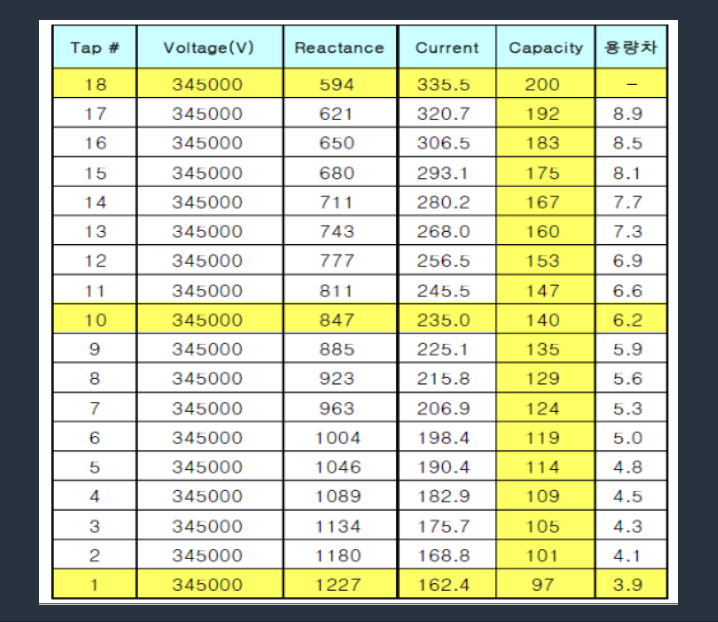

In [20]:
# 투입용량 정보 반영  
all_df['투입용량'] = 0
all_df.loc[all_df['일반1'] == '열림', '투입용량'] += 200
all_df.loc[all_df['일반2'] == '열림', '투입용량'] += 200

for i in range(len(all_df)) :
    tap = all_df.loc[i, '탭1']
    
    if tap == 0 :
        continue
        
    elif tap == 1 :
        all_df.loc[i, '투입용량'] += 97

    elif tap == 2 :
        all_df.loc[i, '투입용량'] += 101
        
    elif tap == 3 :
        all_df.loc[i, '투입용량'] += 105
        
    elif tap == 4 :
        all_df.loc[i, '투입용량'] += 109
        
    elif tap == 5 :
        all_df.loc[i, '투입용량'] += 114
        
    elif tap == 6 :
        all_df.loc[i, '투입용량'] += 119
        
    elif tap == 7 :
        all_df.loc[i, '투입용량'] += 124
        
    elif tap == 8 :
        all_df.loc[i, '투입용량'] += 129
        
    elif tap == 9 :
        all_df.loc[i, '투입용량'] += 135
        
    elif tap == 10 :
        all_df.loc[i, '투입용량'] += 140
        
    elif tap == 11 :
        all_df.loc[i, '투입용량'] += 147
        
    elif tap == 12 :
        all_df.loc[i, '투입용량'] += 153
        
    elif tap == 13 :
        all_df.loc[i, '투입용량'] += 160
        
    elif tap == 14 :
        all_df.loc[i, '투입용량'] += 167
        
    elif tap == 15 :
        all_df.loc[i, '투입용량'] += 175
        
    elif tap == 16 :
        all_df.loc[i, '투입용량'] += 183
        
    elif tap == 17 :
        all_df.loc[i, '투입용량'] += 192
        
    else:
        all_df.loc[i, '투입용량'] += 200
        
# 결과 
all_df['투입용량'].value_counts()

0      150991
200     55583
400      7428
109      2366
140      2345
124      2301
97       2287
119      2275
105      2269
183      2268
135      2265
167      2263
175      2263
101      2250
129      2241
114      2240
192      2234
147      2213
153      2204
160      2204
335      1862
353      1827
347      1812
305      1801
340      1792
383      1792
367      1782
314      1773
375      1772
392      1767
329      1765
309      1761
324      1755
360      1741
319      1740
301      1722
297      1718
505       912
501       887
583       882
553       880
547       873
529       871
519       869
524       858
535       858
560       854
567       847
592       845
509       845
540       844
600       833
514       823
497       818
575       809
Name: 투입용량, dtype: int64

## 3. 최종 결과

In [21]:
# 모든 정보 포함
res1 = pd.read_csv('전압데이터+투입용량.csv')
res1

,시각,전압,가변1,탭1,일반1,일반2,투입용량
0,2021-03-01 00:00:00,349.597094,닫힘,0,닫힘,닫힘,0
1,2021-03-01 00:01:00,353.676500,닫힘,0,닫힘,닫힘,0
2,2021-03-01 00:02:00,353.876387,닫힘,0,닫힘,닫힘,0
3,2021-03-01 00:03:00,352.550220,닫힘,0,닫힘,닫힘,0
4,2021-03-01 00:04:00,354.762645,닫힘,0,닫힘,닫힘,0
...,...,...,...,...,...,...,...
298075,2021-09-23 23:55:00,355.100535,닫힘,0,닫힘,닫힘,0
298076,2021-09-23 23:56:00,353.687462,닫힘,0,닫힘,닫힘,0
298077,2021-09-23 23:57:00,353.178419,닫힘,0,닫힘,닫힘,0
298078,2021-09-23 23:58:00,354.129281,닫힘,0,닫힘,닫힘,0


In [2]:
# 전압과 투입용량 정보만 포함 
res2 = pd.read_csv('전압데이터+투입용량_최종.csv')
res2

,전압,투입용량
0,349.597094,0
1,353.676500,0
2,353.876387,0
3,352.550220,0
4,354.762645,0
...,...,...
298075,355.100535,0
298076,353.687462,0
298077,353.178419,0
298078,354.129281,0


- 가변형 리액터의 탭 파라미터별 혹은 일반 리액터 열림/닫힘 여부별 전압의 변동은 고려하지 않았음  
- 데이터 생성 과정은 큰 의미가 없기 때문에 모델이 학습 가능한 형태로만 데이터 구성  

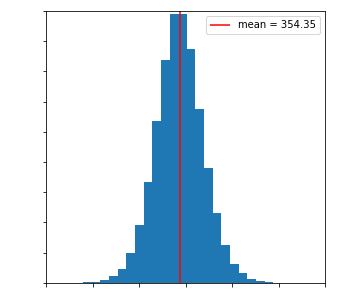

In [35]:
plt.figure(figsize = (5, 5))
plt.hist(res2['전압'], bins = 30)
plt.vlines(res2['전압'].mean(), ymin = 0, ymax = 45000, color = 'red', label = 'mean = {}'.format(np.round(res2['전압'].mean(), 2)))
plt.axis([340, 370, 0, 45000])
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.legend()
# plt.savefig('hist.png')